In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

# for labeling and preprocessing
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# for model
# import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# for
import matplotlib.pyplot as plt

# for saving the model
from tensorflow.keras.models import load_model

# for unzipping
# import gzip
import zipfile
import shutil

2024-02-28 07:55:44.571160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 07:55:44.571253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 07:55:44.734746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Dataset old

In [3]:
# function for image labeling, will make image array directly
def label_images_based_on_folder(root_dir):
    labels = []
    # image_paths = []
    images = []

    # Traverse through the root directory
    for dir_name, subdir_list, file_list in os.walk(root_dir):
        # Iterate over subdirectories
        for subdir_name in subdir_list:
            label = subdir_name  # Use folder name as label
            subdir_path = os.path.join(dir_name, subdir_name)
            # Iterate over files in the subdirectory
            for filename in os.listdir(subdir_path):
                image_path = os.path.join(subdir_path, filename)
                labels.append(label)
                # image_paths.append(image_path)

                # Load image from path
                img = cv2.imread(image_path)
                # convert to grayscale
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # Append preprocessed image to list               
                images.append(img)

    return np.array(images), labels

In [4]:
data_dir = '/kaggle/input/exam-proctoring-dataset/dataset2'
X, labels = label_images_based_on_folder(data_dir)

In [5]:
# function for creating numpy array from image_paths

# def img2numpy(image_paths):
#     images = []
#     for image_path in image_paths:
#         # Load image from path
#         img = cv2.imread(image_path)
#         # Append preprocessed image to list
#         images.append(img)
#     return np.array(images)

label_map = {label: idx for idx, label in enumerate(np.unique(labels))}
print(label_map)

# Convert labels to numerical format (if needed)
def labels_to_numerical(labels, label_map):
    numerical_labels = [label_map[label] for label in labels]
    return np.array(numerical_labels)

{'normal_resized2': 0, 'suspicious_resized2': 1}


In [6]:
# X = img2numpy(image_paths)
# converting to numberical
labels = labels_to_numerical(labels, label_map)

# one hot encoding
labels = to_categorical(labels)

In [7]:
# normalization 
X = X/255

### data splitting old

In [8]:
# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [9]:
# Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5804, 192, 192)
(1452, 192, 192)
(1814, 192, 192)


In [11]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(5804, 2)
(1452, 2)
(1814, 2)


In [12]:
batch_size = 32
auto = tf.data.AUTOTUNE

def make_datasets(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.shuffle(2500)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(auto)

In [13]:
train_set =   make_datasets(X_train, y_train)
val_set =   make_datasets(X_val, y_val)
test_set =  make_datasets(X_test, y_test)

## Model building

In [14]:
# Define the CNN model architecture using functional API
def create_cnn_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    # outputs = layers.Dense(2, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification
    outputs = layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Compile the model
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
def train_model(model, train_data, validation_data, epochs):
    history = model.fit(train_data[0], train_data[1], epochs=epochs,
                        validation_data=validation_data)
    return history

# # Reshape the data (assuming grayscale images)
# X_train = X_train.reshape(-1, height, width, 1)
# X_val = X_val.reshape(-1, height, width, 1)

# input_shape = (height, width, 1)  # Input shape of the images
# num_classes = 1  # Number of classes (binary classification)


# # Train the model
# epochs = 10
# train_data = (X_train, y_train)
# validation_data = (X_val, y_val)
# history = train_model(model, train_data, validation_data, epochs)


In [15]:
# Create the CNN model using functional API
model = create_cnn_model((192,192,1))

# Compile the model
compile_model(model)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 190, 190, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 95, 95, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 93, 93, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       73856 

In [17]:

# Create a callback that saves the model's weights
checkpoint_path2 = '/kaggle/working/model/gpux2_model_w.h5'
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path2,
                                                 monitor = 'val_loss',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [18]:
# Create a callback that saves the model's weights
checkpoint_path1 = '/kaggle/working/model/gpux2_model.h5'
checkpoint1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path1,
                                                 monitor = 'val_loss',
                                                 save_best_only=True,
                                                 verbose=1)

In [19]:
# Train the model using the loaded images and corresponding labels
epochs = 30
history = model.fit(train_set, validation_data=val_set, 
                    epochs=epochs, callbacks=[checkpoint2])

Epoch 1/30


I0000 00:00:1709107025.806487     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


182/182 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.8808
Epoch 1: val_loss improved from inf to 0.15024, saving model to /kaggle/working/model/gpux2_model_w.h5
182/182 [==============================] - 15s 43ms/step - loss: 0.2863 - accuracy: 0.8808 - val_loss: 0.1502 - val_accuracy: 0.9318
Epoch 2/30
181/182 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9525
Epoch 2: val_loss improved from 0.15024 to 0.09874, saving model to /kaggle/working/model/gpux2_model_w.h5
182/182 [==============================] - 6s 36ms/step - loss: 0.1252 - accuracy: 0.9526 - val_loss: 0.0987 - val_accuracy: 0.9649
Epoch 3/30
181/182 [============================>.] - ETA: 0s - loss: 0.0802 - accuracy: 0.9705
Epoch 3: val_loss improved from 0.09874 to 0.06205, saving model to /kaggle/working/model/gpux2_model_w.h5
182/182 [==============================] - 7s 36ms/step - loss: 0.0805 - accuracy: 0.9704 - val_loss: 0.0621 - val_accuracy: 0.9787
Epoch 4/3

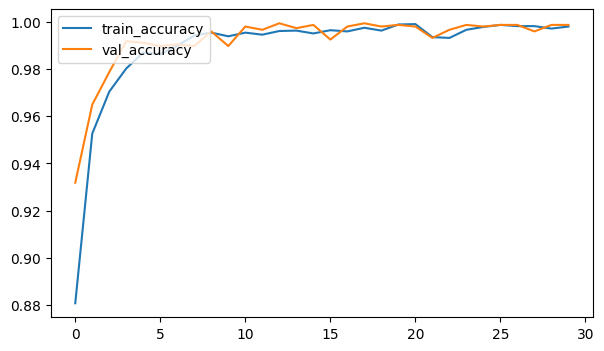

In [20]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

In [21]:
loss_t, acc_t = model.evaluate(test_set)

57/57 [==============================] - 1s 19ms/step - loss: 0.0037 - accuracy: 0.9972


## Model saving

In [22]:
# # saving the model
# model.save("/kaggle/working/model/gpu2_model.h5")

In [23]:
# # saving only weights
# model.save_weights("/kaggle/working/model/gpu2_model_w.keras")

## Loading the saved model and checking its performance

In [24]:
# loading model
model = load_model("/kaggle/working/model/gpu2_model.h5")

In [25]:
# functions for image processing
def process_img(img, img_size=(128,128)):
    # resizing
    processed_img = cv2.resize(img, img_size)
    # grayscale conversion
    processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
    # normalizing
    processed_img = processed_img/255
    return processed_img

In [26]:
frame = cv2.imread("/kaggle/input/exam-proctoring-dataset/dataset2/normal_resized2/sample2_0.jpg")

In [27]:
processed_frame = process_img(frame, (192,192))

In [28]:
processed_frame = np.expand_dims(processed_frame, axis=0)
print(processed_frame.shape)

(1, 192, 192)


In [29]:
prediction = model.predict(processed_frame)

1/1 [==============================] - 0s 305ms/step


In [30]:
print(prediction, prediction.shape)

[[1. 0.]] (1, 2)


In [31]:
# get the index of the class with the highest probability (argmax)
predicted_index = np.argmax(prediction)
predicted_index

0

In [32]:
# defining the label mapping if not already done
label_map = {0:'normal', 1:'suspicious'}

In [33]:
# convert the predicted index to the corresponding original label
predicted_label = label_map[predicted_index]

In [34]:
print(predicted_label)

normal


In [35]:
# function for capturing video

def collect_video(output_path, num_samples):
    '''
    This function captures video from the default camera and saves the video in the specified directory.
    '''
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    capture = cv2.VideoCapture(0)
    
    sample_count = 0
    
    while True:
        ret, frame = capture.read()
        
#         cv2.imshow('Frame', frame)
        
        f_name = os.path.join(output_path, f'sample_{sample_count}.jpg')
        cv2.imwrite(f_name, frame)
        print(f"Saved: {f_name}")
        
        sample_count += 1
        
        if sample_count >= num_samples:
            break
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    capture.release()
    cv2.destroyAllWindows()
            

In [36]:
# output_path = './video_not_cheat'
# num_samples = 10
# collect_video(output_path, num_samples)

In [37]:
# function for capturing video

def collect_video(output_path, num_samples):
    '''
    This function captures video from the default camera and saves the video in the specified directory.
    '''
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    capture = cv2.VideoCapture(0)
    
    sample_count = 0
    
    while True:
        ret, frame = capture.read()
        
        cv2.imshow('Frame', frame)
        
        f_name = os.path.join(output_path, f'sample_{sample_count}.jpg')
        cv2.imwrite(f_name, frame)
        print(f"Saved: {f_name}")
        
        sample_count += 1
        
        if sample_count >= num_samples:
            break
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    capture.release()
    cv2.destroyAllWindows()
            